In [1]:
# !mkdir -p data
# !wget --no-check-certificate 'https://drive.google.com/u/2/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download' -O data/test_data.tar.gz

In [2]:
# !tar -xzvf data/test_data.tar.gz --directory data
# !ls -ltrh data

In [3]:
import torch
import mgplvm as mgp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
from scipy.stats import poisson

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel
from sklearn.model_selection import train_test_split

import scipy.io as sio
import pandas as pd

from synthetic_data import *

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import acovf

from scipy import signal

loading


In [4]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb'))
fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': 25}
Y = fit_data['Y']
locs = fit_data['locs']
ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
vels = cs(ts, 1) # velocity (first derivative)
print(vels.shape)
sio.savemat('vels.mat', {'vels': vels})


(70482, 2)


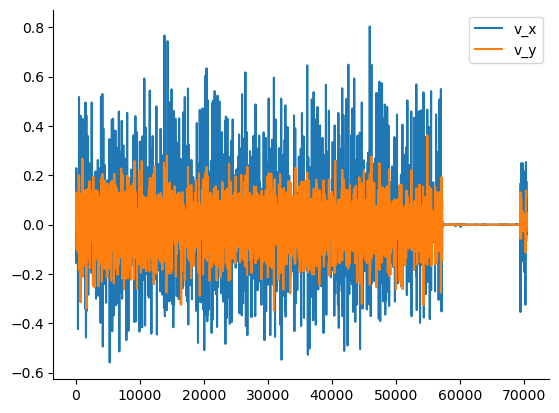

In [5]:
x = np.arange(vels.shape[0])
v_x = vels[:,0]
v_y = vels[:,1]
plt.plot(x, v_x, label='v_x')
plt.plot(x, v_y, label='v_y')
plt.legend()
plt.show()

7.65**2 * RBF(length_scale=1.93) + WhiteKernel(noise_level=0.000141)
-2651.393688853587
0.9999995659558663


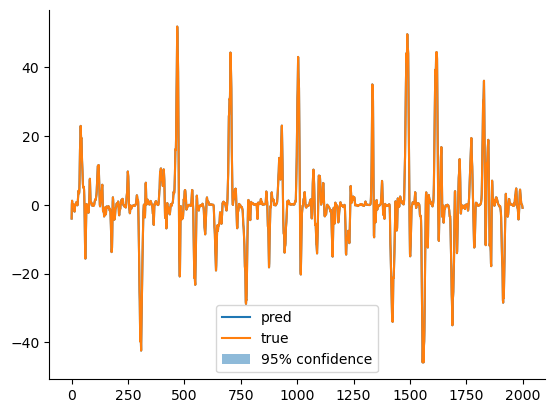

10.6**2 * Matern(length_scale=44.1, nu=0.5) + WhiteKernel(noise_level=1.77e-08)
-4417.0757311308125
0.9999907146351352


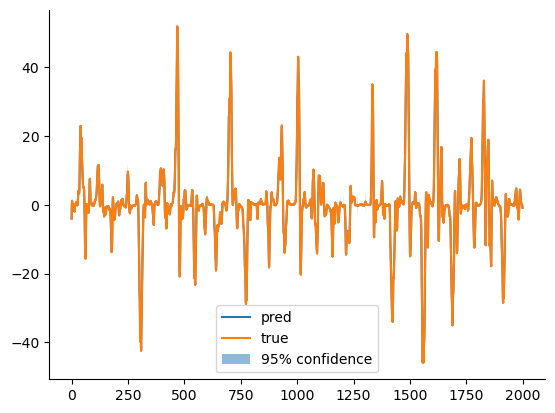

12.5**2 * Matern(length_scale=10.3, nu=1.5) + WhiteKernel(noise_level=5.95e-09)
-3111.145282787884
0.9999993428263143


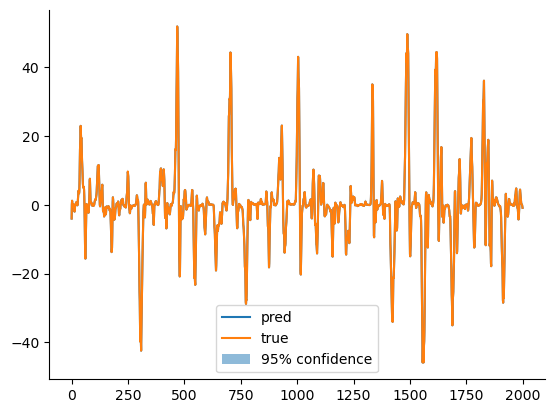

/home/ayush/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


9.27**2 * RationalQuadratic(alpha=2.02, length_scale=2.97) + WhiteKernel(noise_level=1e-10)
-2380.276735284347
0.9999998893228512


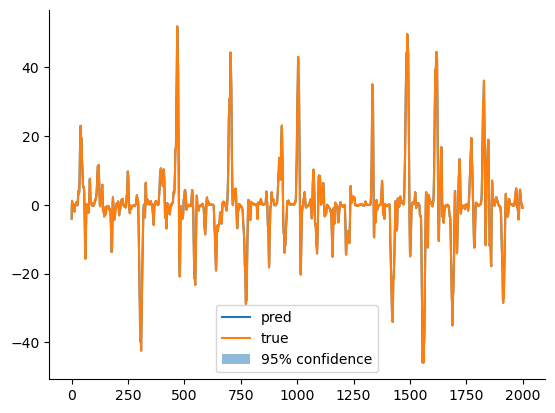

In [6]:
# kernels = [RationalQuadratic(alpha=1, length_scale=1, length_scale_bounds=(1e-1, 10)), ]
# train_len = 50
# test_len = 100
# train_x = x[:train_len]
# train_v_x = v_x[:train_len]
# test_x = x[train_len:test_len+train_len]
# test_v_x = v_x[train_len:test_len+train_len]
# total_x = np.concatenate([train_x, test_x])
# total_v_x = np.concatenate([train_v_x, test_v_x])

total_x = x[:2000]
total_v_x = v_x[:2000]*100
# train_x = total_x[::2]
# train_v_x = total_v_x[::2]
# test_x = total_x[1::2]
# test_v_x = total_v_x[1::2]
train_x, test_x, train_v_x, test_v_x = train_test_split(total_x, total_v_x, test_size=0.01, random_state=0)
# total_x2 = np.linspace(0, 100, 1000)
total_x2 = total_x


kernels = np.array([10*RBF(length_scale=10, length_scale_bounds=(1e-5, 1000)) #+ 10*RBF(length_scale=100, length_scale_bounds=(1e-5, 1000)) + 10*RBF(length_scale=10, length_scale_bounds=(1e-5, 1000))+ 10*RBF(length_scale=1, length_scale_bounds=(1e-5, 1000))+ 10*RBF(length_scale=1000, length_scale_bounds=(1e-5, 1000))+ 1*RBF(length_scale=10, length_scale_bounds=(1e-5, 1000))+ 1*RBF(length_scale=100, length_scale_bounds=(1e-5, 1000))+ 1*RBF(length_scale=1000, length_scale_bounds=(1e-5, 1000))
                    , 10*Matern(nu=0.5, length_scale=10, length_scale_bounds=(1e-5, 1000)), 5*Matern(nu=1.5, length_scale=10, length_scale_bounds=(1e-5, 1000)), 5*RationalQuadratic(alpha=1, length_scale=5, length_scale_bounds=(1e-5, 1000))])
kernels += np.array([WhiteKernel(noise_level=10, noise_level_bounds=(1e-10, 1e5)) for _ in range(4)])
for i, kernel in enumerate(kernels):
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(train_x.reshape(-1,1), train_v_x.reshape(-1,1))
    print(gpr.kernel_)
    print(gpr.log_marginal_likelihood())
    print(gpr.score(total_x.reshape(-1,1), total_v_x.reshape(-1,1)))
    mu, std = gpr.predict(total_x2.reshape(-1,1), return_std=True)

    # %matplotlib ipympl
    # plt.ion()
    plt.plot(total_x2, mu, label='pred')
    plt.plot(total_x, total_v_x, label='true')
    plt.fill_between(total_x2, mu-1.96*std, mu+1.96*std, alpha=0.5, label='95% confidence')
    # plt.plot(train_x, train_v_x, 'x', label='train')
    plt.legend()
    plt.show()

    # break


# mean, std = gpr.predict(x.reshape(-1,1), return_std=True)
# plt.plot(x, mean, label='mean')
# plt.fill_between(x, mean-std, mean+std, alpha=0.5, label='std')
# plt.legend()
# plt.show()


/home/ayush/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/ayush/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


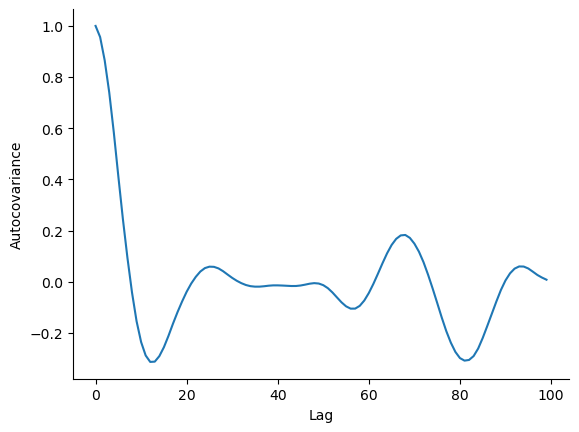

In [7]:

v_x2 = v_x[1000:1100]
# plot_acf(v_x2, lags=len(v_x2)-1, fft=False)
autocorr_values = acf(v_x2, nlags=len(v_x2)-1, fft=False)
plt.plot(autocorr_values)
plt.xlabel('Lag')
plt.ylabel('Autocovariance')
# plt.show()

arr_len = len(v_x2)
autocor = np.zeros(arr_len)
for i in range(arr_len):
    autocor[i]=pd.Series.autocorr(pd.Series(v_x2),lag=i)
# plt.plot(autocor)
plt.show()


In [8]:
# x_axis = np.linspace(0, 1000, 1000)
# l = 30.0

# K = squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l)
# num_funcs = 5
# samples = np.random.multivariate_normal(mean=np.zeros(len(x_axis)), cov=K, size=num_funcs)
# plt.plot(x_axis, samples.T)
# plt.title('Squared exponential kernel')
# plt.show()
# print(samples.shape)
# for i in range(num_funcs):
#     autocorr_values = acf(samples[i], nlags=len(samples[i])-1, fft=False)[:100]
#     autocov_values = acovf(samples[i], nlag=len(samples[i])-1, fft=False)[:100]
#     plt.plot(autocorr_values**2)
#     # plt.plot(autocov_values)
# plt.plot(x_axis[:100], squared_exponential_kernel(x_axis, l)[:100], label='kernel')
# plt.xlabel('Lag')
# plt.ylabel('Autocovariance')
# plt.legend()
# plt.show()


In [9]:
# data = sio.loadmat('cw1a.mat')

In [10]:
# x2 = data['x'].flatten()
# y2 = data['y'].flatten()
# x2, y2 = list(zip(*sorted(zip(x2, y2))))
# x2 = np.array(x2)
# y2 = np.array(y2)

# kernel = 1.0 * RBF(length_scale=0.1, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
# gpr = GaussianProcessRegressor(kernel=kernel)
# gpr.fit(x2.reshape(-1,1), y2.reshape(-1,1))
# print(gpr.kernel_)
# print(gpr.log_marginal_likelihood())
# print(gpr.score(x2.reshape(-1,1), y2.reshape(-1,1)))
# x_axis = np.linspace(-3, 3, 1000)
# mu2, std2 = gpr.predict(x_axis.reshape(-1,1), return_std=True)
# plt.plot(x_axis, mu2, label='pred')
# # plt.plot(x2, y2, label='true')
# plt.plot(x2, y2, 'x', label='train')
# plt.fill_between(x_axis, mu2-1.96*std2, mu2+1.96*std2, alpha=0.5, label='95% confidence')
# plt.legend()
# plt.show()

In [11]:
# x = np.linspace(0, 3*np.pi, 100)
# y_true = np.sin(x)
# y = y_true + np.random.normal(0, 0.2, 100)
# x = x.reshape(-1,1)
# y = y.reshape(-1,1)
# kernel = 1.0 * RBF(length_scale=0.1, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
# gpr = GaussianProcessRegressor(kernel=kernel)
# gpr.fit(x, y)
# print(gpr.kernel_)
# print(gpr.log_marginal_likelihood())
# print(gpr.score(x, y))
# x_axis = np.linspace(-3*np.pi, 3*np.pi, 1000)
# mu, std = gpr.predict(x_axis.reshape(-1,1), return_std=True)
# plt.plot(x_axis, mu, label='pred')
# plt.plot(x, y, 'x', label='train')
# plt.plot(x_axis, np.sin(x_axis), label='true')

# plt.fill_between(x_axis, mu-1.96*std, mu+1.96*std, alpha=0.5, label='95% confidence')
# plt.legend()
# plt.show()


0.714**2 * RBF(length_scale=0.0398) + WhiteKernel(noise_level=0.0011)
1454.531797476936
0.8979365108944024


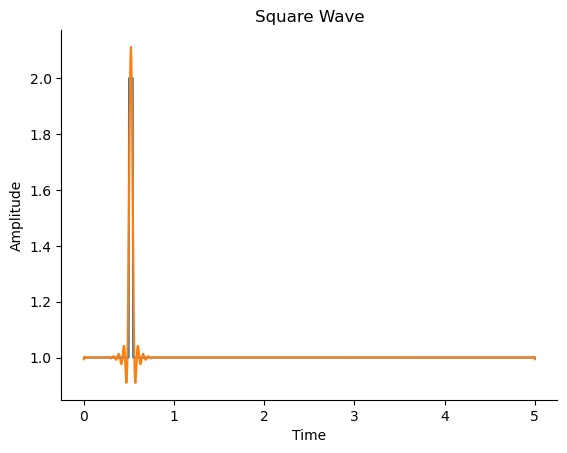

In [12]:

# Specify the width of the square wave
width = 9

# Generate the time axis
t = np.linspace(0, 5, 1000)

# Generate the square wave

square_wave = np.ones(len(t))
square_wave[100:100+width] += 1

# Plot the square wave
plt.plot(t, square_wave)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Square Wave')

# Fit GPR using SE kernel
kernel = 1.0 * RBF(length_scale=1, length_scale_bounds=(1e-5, 10.0)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
# kernel = 1.0 * RationalQuadratic(alpha=1, length_scale=1, length_scale_bounds=(1e-5, 10.0)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e5))
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(t.reshape(-1,1), square_wave.reshape(-1,1))
print(gpr.kernel_)
print(gpr.log_marginal_likelihood())
print(gpr.score(t.reshape(-1,1), square_wave.reshape(-1,1)))
mu, std = gpr.predict(t.reshape(-1,1), return_std=True)
plt.plot(t, mu, label='pred')

plt.show()
